<a href="https://colab.research.google.com/github/submouse9903/test-1/blob/master/U47768_CH05_RNN(%EA%B0%90%EC%84%B1%EB%B6%84%EC%84%9D_dataPreprocessing).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN을 이용한 텍스트 분류(Text Classification)

## 1) 영화 평점 데이터를 이용한 감성 분석 데이터 전처리

영화 평가에 대한 텍스트 데이터(predictor)와 영화 평점 (response) 데이터 쌍을 이용하여 어떤 문장의 감성을 평가하는 데이터

(참고) 데이터의 domain 이 영화평에 관련 된 것이기 때문에 학습된 모형을 텍스트의 감성분류에 일반화하여 적용할 수는 없다.

### - 데이터
: 이 실습에서 사용하는 데이터는 https://github.com/lih0905/korean-pytorch-sentiment-analysis 에 있는 영화 평점 데이터를 활용하였다.

In [ ]:
!pip install konlpy
import pandas as pd 
import numpy as np
import torch
import torchtext
from konlpy.tag import Okt
import collections
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 33.4 MB/s eta 0:00:00


- 형태소 분석기 사용 실습

In [ ]:
okt=Okt()  
text = "형태소 분석를 사용하여 실습을 해 봅시다"
print(okt.morphs(text))
print(okt.pos(text))  
print(okt.nouns(text))  

['형태소', '분석', '를', '사용', '하여', '실습', '을', '해', '봅시다']
[('형태소', 'Noun'), ('분석', 'Noun'), ('를', 'Noun'), ('사용', 'Noun'), ('하여', 'Verb'), ('실습', 'Noun'), ('을', 'Josa'), ('해', 'Noun'), ('봅시다', 'Verb')]
['형태소', '분석', '를', '사용', '실습', '해']


In [ ]:
x = okt.morphs(text)
type(x)

list

- 영화 평점 데이터를 불러봅시다. 

In [ ]:
train_data = pd.read_csv("http://ranking.uos.ac.kr/class/RB/rating_train.csv")
test_data = pd.read_csv("http://ranking.uos.ac.kr/class/RB/rating_test.csv")

In [ ]:
train_data.head()

,id,text,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
text = train_data["text"][0]
okt.morphs(text)

['아', '더빙', '..', '진짜', '짜증나네요', '목소리']

- collections 모듈에 있는 defaultdict 을 이용하여 word (token)의 개수를 센다.
- defaultdict 의 원래기능은 dictionary 를 초기화 하는 것인데 key를 통해 값을 호출할 때 초기값을 가지고 있다는 점이 다르다. 

In [ ]:
morph_counter = collections.defaultdict(int)
print("morph_counter는 초기화 된 상태로 어떠한 key 도 없습니다.")
print(morph_counter["unknown_key"])

morph_counter는 초기화 된 상태로 어떠한 key 도 없습니다.
0


In [ ]:
morph_counter["형태소 원소"] =+1
morph_counter

defaultdict(int, {'unknown_key': 0, '형태소 원소': 1})

In [ ]:
from tqdm import tqdm 
morph_counter = collections.defaultdict(int)
text_line = train_data["text"]
for text in tqdm(text_line):
  for m in okt.morphs(text):
    morph_counter[m] += 1

100%|██████████| 149995/149995 [08:10<00:00, 305.57it/s]


- 빈도수가 높은 토큰 확인

In [ ]:
most_freq = sorted(morph_counter.items(), key=lambda item: item[1], reverse=True)
print(most_freq[:10])

[('.', 67784), ('이', 56108), ('영화', 50737), ('의', 30963), ('..', 29058), ('가', 27571), ('에', 26772), ('을', 23237), ('...', 22801), ('도', 21426)]


In [ ]:
label_vec = [j for (j,k) in most_freq]
freq_vec = [k for (j,k) in most_freq]

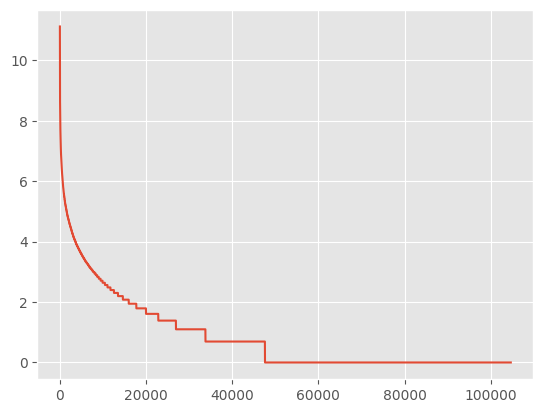

In [ ]:
plt.style.use('ggplot')
plt.plot(np.log(freq_vec))

- cut_value 를 정하기 위한 분석: cut_value를 잡았을 때 몇개의 unique word 가 남는지 계산한다.
- freq_vec 은 단어별로 빈도수를 가지고 있기 때문에 빈도수의 값을 범주형 변수로 보고 그것의 빈도를 계산하면, 빈도 수가 $k$인 unique word 의 개수를 알 수 있다. 
- cut_value 에 따른 unique word 의 누적합을 계산한다.


In [ ]:
# 빈도가 k개인 단어의 개수
freq_pd = pd.DataFrame(freq_vec)
freq_pd = freq_pd.value_counts()
print("단어의 전체수:", freq_pd.sum())
print("빈도가 k개인 단어의 개수:\n", freq_pd)

1        57087
2        13814
3         6848
4         4100
5         2854
         ...  
764          1
760          1
759          1
748          1
67784        1
Length: 897, dtype: int64

(0.0, 10.0)

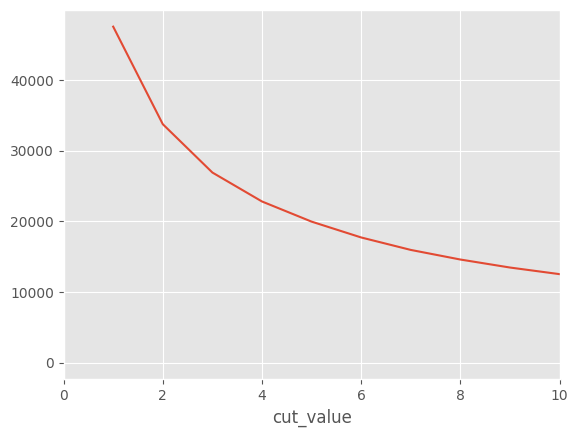

In [ ]:
# freq_pd의 index 가 내림차순으로 정렬되지 않았기 때문에 다음과 같이 정렬한다. 
freq_index = np.array([freq_pd.index[i][0] for i in range(len(freq_pd))])
idx = np.argsort(freq_index)
freq_pd_idx = np.sort(freq_index)
freq_pd_v = np.array([freq_pd.iloc[idx[i]] for i in range(len(idx))])
v = freq_pd.sum() - freq_pd_v.cumsum()
plt.plot(freq_pd_idx, v)
plt.xlabel("cut_value")
plt.xlim(0,10)

- word cnt 가 cut_value 보다 작은 토큰들을 제거한다. dict에서 제거하기 위해서 dict를 하나 복사하여 거기에 있는 값을 이용한다. 이는 반복문을 사용하면서 dict를 같이 변환할 수 없기 때문이다. 
- copy 를 새로운 객체를 생성하는 것이 중요하다. (값이 같이 변화하면 안됨) 예를 들어 morph_counter_copy = morph_counter 로 정의한 morph_counter_copy 는 같은 메모리를 참조하기 때문에 morph_counter의 원소를 지우면 해당 위치의 morph_counter_copy 원소도 같이 지워진다. 

In [ ]:
print("전처리 전:", len(morph_counter))
cut_value = 4
morph_counter_copy = morph_counter.copy()
for key, value in morph_counter_copy.items():
  if (value<=cut_value):
    del morph_counter[key]
print("전처리 후:", len(morph_counter))

전처리 전: 20617
전처리 후: 20617


- 형태소-id 가 대응되는 vocabulary 를 만든다.

In [ ]:
morph_to_id = {'[PAD]': 0, '[UNK]': 1}
for w, cnt in morph_counter.items():
    morph_to_id[w] = len(morph_to_id)
print(len(morph_to_id))

NameError: ignored

- id-형태소가 대응되는 vocabulary 를 만든다.

In [ ]:
id_to_morph = {}
for w, idx in morph_to_id.items():
  id_to_morph[idx] = w
print(len(id_to_morph))  

{0: '[PAD]',
 1: '[UNK]',
 2: '짜증나네요',
 3: '가볍지',
 4: '무재',
 5: '다그',
 6: '래서',
 7: '보는것을',
 8: '교도소',
 9: '구먼',
 10: '조정',
 11: '돋보였던',
 12: '스파이더맨',
 13: '늙어',
 14: '이뻐',
 15: '보였다',
 16: '걸음',
 17: '생인',
 18: '이응경',
 19: '납치',
 20: '감금',
 21: '없는데도',
 22: '인피니트',
 23: '죽겠다',
 24: '향수',
 25: '허진호',
 26: '절제',
 27: '달인',
 28: '울면',
 29: '뛰',
 30: '이범수',
 31: '담백하고',
 32: '깔끔해서',
 33: '이었다는',
 34: '존중',
 35: '다지',
 36: '어거지',
 37: '매번',
 38: '재밋음',
 39: '웃긴게',
 40: '바스코',
 41: '락스',
 42: '까고',
 43: '바비',
 44: '안달',
 45: '굿바이',
 46: '레닌',
 47: '깨알',
 48: '산뜻한',
 49: '용구성',
 50: '일드',
 51: '변명',
 52: '심오한',
 53: '선생',
 54: '놀아나는',
 55: '웃지',
 56: '불가능하다',
 57: '음식',
 58: '만찬',
 59: '핀란드',
 60: '납득',
 61: '꺼야',
 62: 'g',
 63: '고추',
 64: '버려야',
 65: '할텐데',
 66: '카밀라',
 67: '벨',
 68: '센스',
 69: '탁월한',
 70: '위력',
 71: '꽃',
 72: '검사',
 73: '졸',
 74: '됌',
 75: '1%',
 76: '기대했던',
 77: '죄인',
 78: '패션',
 79: '윈',
 80: '투어',
 81: '키이라',
 82: '나이틀리',
 83: '했던건',
 84: '허허',
 85: '나간',
 86: '유령',
 87

In [ ]:
id_to_morph.get(10)

'줄'

- 데이터 전처리를 한다. 
- maximum length를 잡고

In [ ]:
# recall
train_data.head()

,id,text,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
# '[PAD]': 0, '[UNK]': 1
# pre-padding 기준으로 
max_length = 9
text = train_data["text"][0]
text_list = okt.morphs(text)
print("text_list:", text_list)
print("len of text_list:", len(text_list))

# 입력 text 가 최대 길이보다 짧은거나 같은 경우
m =  max_length-len(text_list)
if m>=0:
  text_list_id = [0 if i<m else morph_to_id.get(text_list[i-m],1) for i in range(max_length)]
# 입력 text 가 최대 길이보다 긴 경우
else:
  text_list_id = [morph_to_id.get(text_list[i],1) for i in range(max_length)]
print(text_list_id)

[0, 0, 0, 1, 1, 1, 1, 2, 1]

In [ ]:
def textEncoding(text_list, max_length, morph_to_id):
  m =  max_length-len(text_list)
  if m>=0:
    text_list_id = [0 if i<m else morph_to_id.get(text_list[i-m],1) for i in range(max_length)]
  # 입력 text 가 최대 길이보다 긴 경우
  else:
    text_list_id = [morph_to_id.get(text_list[i],1) for i in range(max_length)]
  return text_list_id

In [ ]:
textEncoding(text_list, 9, morph_to_id)

[0, 0, 0, 2, 3, 4, 5, 1, 1]

In [ ]:
X = []
for text in tqdm(train_data["text"]):
  text_list = okt.morphs(text)
  X.append(textEncoding(text_list, 9, morph_to_id))

100%|██████████| 1000/1000 [00:04<00:00, 244.30it/s]


In [ ]:
from torch.utils.data import TensorDataset
X_t = torch.tensor(X)
#train = TensorDataset(train_data["text"], train_data['label'])

In [ ]:
Y_t = torch.tensor(train_data["label"])
tr_data = TensorDataset(X_t, Y_t)

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(tr_data, batch_size=5, shuffle=True)

In [ ]:
for i, j in train_dataloader:
  print(i)
  print(j)
  break

tensor([[  1, 114,   1,   1,   1,  76,   1,   1,  81],
        [  0,   0,   0,   0,   0,   0,   0,  12, 401],
        [  1,   1,   1,   1, 162,   1, 123, 162,   1],
        [  0,   0,   0,   0,   0,   0,   0,   1,   6],
        [134,   1,   9,  15,  92,  32,   8, 150,  44]])
tensor([1, 1, 1, 0, 1])


In [ ]:
embedding = torch.nn.Embedding(len(morph_to_id), 40, padding_idx = 0)

In [ ]:
for x, y in train_dataloader:
  z = embedding(x)
  print("shape of embedding vector:", z.shape)
  break

shape of embedding vector: torch.Size([5, 9, 40])
